# Volatility Surface with calendar Arbitrage 

In [1]:
import numpy as np
import pandas as pd
import math
from scipy import *
from scipy.optimize import *
import sys
import quadpy
import numba 
from numba import jit
from scipy.integrate import quad
from yahoo_fin.options import *
import yfinance as yf
from pandas import ExcelWriter
from yahoo_fin import stock_info as si
from pandas_datareader import data as wb
from datetime import timedelta, date
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from dateutil.parser import parse

In [667]:
Ticker=['^GSPC']
df=pd.DataFrame()
for i in Ticker:
    df[i]=wb.DataReader(i,'yahoo', start='01-09-2005')['Adj Close']
df

,^GSPC
Date,
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951
2005-01-14,1184.520020
2005-01-18,1195.979980
2005-01-19,1184.630005
2005-01-20,1175.410034
2005-01-21,1167.869995


In [668]:
df2 = np.log(df/df.shift()).dropna()

In [669]:
from numba import njit
import warnings
warnings.filterwarnings('ignore')

In [762]:
class NGARCH :
    def __init__(self,df,S,K,T,r = 0):
        
        self.df = np.array(df)
        self.T = T
        self.r = r
        self.S = S
        self.K = np.array(K)
        self.mu = np.mean(self.df)
        self.NGarch_Log_Like()
        self.NGarch_Model()
        
    def NGarch(self,params):
        w,Beta,alpha,y,lambda_  = params
        if (w < 1e-120 or 1 - alpha * y**2 - Beta < 1e-2 or alpha < 1e-12 
                    or w > 1e-04 or alpha > 1e-04 or y < 1e-3 or y > 1e3 or lambda_ < 1e-3 or
                    lambda_ > 100 or Beta < 1e-3 or Beta > 0.99):
                    return 1e50
        h = np.zeros(len(self.df))
        e = np.zeros(len(self.df))
        mu = np.mean(self.df)
        for i in range(0,len(self.df)):
            if i == 0:
                h[0] = (w + alpha) / ( 1 - alpha * y**2 - Beta )
                e[0] = (self.df[0] - self.r - lambda_ * h[0] + h[0]/2)/np.sqrt(h[0])
            else :
                h[i] = w + Beta * h[i-1] + alpha * (e[i-1] - y * np.sqrt(h[i-1]))**2
                e[i] = (self.df[i] - self.r - lambda_ * h[i] + h[i]/2)/np.sqrt(h[i])
        LogL = - .5 * np.sum(-np.log( 2 * np.pi) - np.log(h) - (e)**2)
        return LogL
    
    def NGarch_Model(self):
        h = np.zeros(len(self.df))
        e = np.zeros(len(self.df))
        for i in range(0,len(self.df)):
            if i == 0:
                h[0] = (self.w + self.alpha) / (1 - self.alpha * self.y**2 - self.Beta)
                e[0] = (self.df[0] - self.r - self.lambda_ * h[0] + h[0]/2 )/np.sqrt(h[0])
            else :
                h[i] =  self.w + self.Beta * h[i-1] + self.alpha * (e[i-1]- self.y * np.sqrt(h[i-1]))**2
                e[i] = (self.df[i] - self.r - self.lambda_ * h[i] + h[i]/2)/np.sqrt(h[i])
        self.Conditional_standard_dev = np.sqrt(h)
        self.innovations = e
        return h,e

    def NGarch_Forecasts_Model(self):
        h = np.ones(self.T) * (self.Conditional_standard_dev[-1])**2
        e = np.ones(self.T) * self.innovations[-1]
        for i in range(1, self.T):
                h[i] =  self.w + self.Beta * h[i-1] + self.alpha * (h[i-1]) + self.alpha *(self.y * np.sqrt(h[i-1]))**2
        self.CV_forecast = h
        return h
   
    def NGarch_Log_Like(self):
        w,Beta,alpha,y,lambda_ =  5.02e-06, 0.70 ,1.32e-06 , 421.39, 0.205
        x0 = np.array([w,Beta,alpha,y,lambda_])
        cons = ({'type': 'ineq', 'fun': lambda x: 1-x[1]-x[2]*(x[3]**2)})
        bounds = [(1e-120,1e-05),(1e-6,1),(1e-12,1e-05),(1,1e3),(1e-3,100)]
        sol = minimize(self.NGarch,x0,method = 'Nelder-Mead',options = {'disp':True,'maxiter':25},tol = 1e-9)
        self.w,self.Beta,self.alpha,self.y,self.lambda_ = sol.x
        #print("Log Likelihood : {} ".format(-sol.fun))
        #print(100 * "-")
        #print("Stationarity Conditon : ", self.Beta + self.alpha * self.y**2 )
        #print(100 * "-")
        #print(" Parameters : ",sol.x)
        #print(100 * "-")
        
    @staticmethod
    @jit(nopython=True)
    def Computator(A,B,w,alpha,Beta,y,phi,r,T,lambda_,K,S,FuncNum,V):
        A = [x for x in range(0,T)]#np.zeros(T,dtype=np.complex128) 
        B = [x for x in range(0,T)]
        for t in range(1,T) : 
            if FuncNum == 1:
                A[t] = A[t - 1] + (1j*phi + 1) * r + B[t - 1] * w - 0.5 * np.log( 1.0 - 2.0 * alpha * B[t - 1])
                B[t] = (1j * phi + 1) * (lambda_ + y) - 0.5 * y * y + Beta * B[t - 1] + (0.5 * ( 1j * phi + 1 - y) * ( 1j * phi + 1 - y))/(1.0 - 2.0 * alpha * B[t - 1])
            else : 
                A[t] = A[t - 1] + ( 1j * phi ) * r + B[t - 1] * w - 0.5 * np.log(1.0 - 2.0 * alpha * B[t - 1])
                B[t] = 1j * phi * (lambda_ + y) - 0.5 * y * y  + Beta * B[t - 1] + ( 0.5 * ( 1j * phi - y) ** 2) / (1.0 - 2.0 * alpha * B[t - 1] )
        if FuncNum == 1:
            z = (S ** (1j * phi + 1)) * np.exp(A[-1] + B[-1] * V)
            return z.real + z.imag * 1j
        else : 
            z = (S ** ( 1j * phi)) * np.exp(A[-1] + B[-1] * V)
            return z.real + z.imag * 1j
        
    @staticmethod    
    @jit(nopython=True)   
    def Characteristic_Function_2(A,B,w,alpha,Beta,y,r,T,lambda_,S,V):
        for t in range(1,T) :
            A[t] = A[t - 1] + (1) * r + B[t - 1] * w \
                   - 0.5 * np.log( 1.0 - 2.0 * alpha * B[t - 1])
            B[t] = (1) * (lambda_ + y) - 0.5 * y ** 2 + Beta * B[t - 1] + (0.5 * (1 - y) ** 2)/(1.0 - 2.0 * alpha * B[t - 1])
                
        z = S * np.exp(A[-1] + B[-1] * V)
        
        return np.real(z)
    
    
    def Characteristic_Function(self,phi,FuncNum,j,A,B,V): #V is unconditional Varianc3
        
        #A = np.zeros(self.T,dtype = complex)
        #B = np.zeros(self.T,dtype = complex)
        #V = self.NGarch_Forecasts_Model()[0][-1]
        #A[0] = 0
        #B[0] = 0
        # Recursion backward in time (first is last in the matrix)
        for t in range(1,self.T) :
            if FuncNum == 1 :
                A[t] = A[t - 1] + (1j * phi + 1) * self.r + B[t - 1] * self.w \
                   - 0.5 * np.log( 1.0 - 2.0 * self.alpha * B[t - 1])
                B[t] = (1j * phi + 1) * (self.lambda_ + self.y) - 0.5 * self.y ** 2 \
                   + self.Beta * B[t - 1] + (0.5 * (1j*phi + 1 - self.y) ** 2)/(1.0 - 2.0 * self.alpha * B[t - 1])
            else: 
                A[t] = A[t - 1] + ( 1j * phi ) * self.r + B[t - 1] * self.w \
                   - 0.5 * np.log(1.0 - 2.0 * self.alpha * B[t - 1])
                B[t] = 1j * phi * (self.lambda_ + self.y) - 0.5 * self.y ** 2 + self.Beta * B[t - 1] \
                   + ( 0.5 * ( 1j * phi - self.y) ** 2) / (1.0 - 2.0 * self.alpha * B[t - 1])

        if FuncNum == 1:
            z = self.K[j]**(-phi * 1j) * (self.S ** (1j * phi + 1)) * np.exp(A[-1] + B[-1] * V)
            return z
        else:
            z = self.K[j]**(-phi * 1j) * (self.S ** ( 1j * phi)) * np.exp(A[-1] + B[-1] * V)
            return z
    
    def Second_Optim(self):
        P1 = np.zeros(len(self.K))
        P2 = np.zeros(len(self.K))
        A = np.zeros(self.T,dtype = np.complex128)
        B = np.zeros(self.T,dtype = np.complex128) 
        V = self.NGarch_Forecasts_Model()[-1]
        m = self.Characteristic_Function_2(A,B,self.w,self.alpha,self.Beta,self.y,self.r,self.T,self.lambda_,self.S,V)
        for i in range(0,len(self.K)):
            #cf1 = lambda g : self.Computator(A,B,self.w,self.alpha,self.Beta,self.y,g,self.r,self.T,self.lambda_,self.K[i],self.S,1,V)/(self.S * 1j * g)
            cf1 = lambda g : self.Characteristic_Function(g,1,i,A,B,V)/(m * 1j * g)
            P1[i] = np.maximum(1/2 + quad(cf1,0,np.inf)[0] * 1/np.pi,0)
            #cf2 = lambda g : self.Computator(A,B,self.w,self.alpha,self.Beta,self.y,g,self.r,self.T,self.lambda_,self.K[i],self.S,0,V)/(1j * g)
            cf2 = lambda g : self.Characteristic_Function(g,0,i,A,B,V)/(1j * g)
            P2[i] = np.maximum(1/2 + quad(cf2,0,np.inf)[0] * 1/np.pi,0)
        return P1,P2,m
        
    def Option_Premiums(self):
        P1,P2,m = self.Second_Optim()
        M = m * P1 - self.K * P2
        M[M < 0] = 0
        return M      
        

In [768]:
%%time
f = NGARCH(df2,4232.60,[7500,4250],252,0.01/360)

CPU times: user 1.71 s, sys: 6.16 ms, total: 1.71 s
Wall time: 1.72 s


In [769]:
%%time
f.Option_Premiums()

CPU times: user 4.45 s, sys: 19 ms, total: 4.47 s
Wall time: 4.49 s


array([  0.        , 279.71981912])

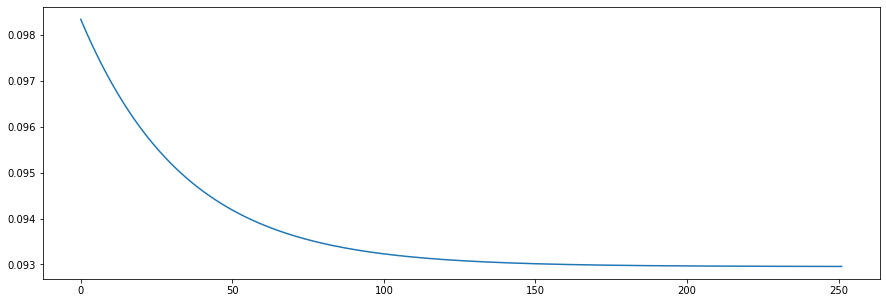

In [748]:
plt.figure(figsize=(15,5))
plt.plot(np.sqrt(f.CV_forecast)*252**(1/2)) 

In [750]:
import datetime 
from datetime import date
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')
L.iloc[:,1] = L.iloc[:,1]
L.iloc[:,2] = L.iloc[:,2]
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360


In [985]:
from scipy import optimize
from scipy.stats import norm

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price


def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM

def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    #res = optimize.fmin(Optimisor, 0.01,(args,))
    try:
        res = optimize.brentq(Optimisor,0.0001,10000,args,maxiter=10000)
    except :
        res = np.nan
    #res = least_squares(Optimisor, 2,args = (args,))
    #res = minimize(Optimisor, 0.05,args)
    return res

In [883]:
%%time
m = {}
#volatility = {}
TTM = np.round(L.sort_values(by = 'TTM').TTM.unique() * 360,0)
i = 0
print(i)
m = []
Q = L.groupby(["TTM","Strikes"]).mean()
for i,T in enumerate(TTM):
    f = NGARCH(df2,4163.26,Q.loc[L.sort_values(by = 'TTM').TTM.unique()[i]].index.values,int(T),0)
    m.append(f.Option_Premiums())

0
CPU times: user 7min 41s, sys: 313 ms, total: 7min 41s
Wall time: 7min 41s


In [935]:
Fm = pd.DataFrame(m)
jk = Fm.values.reshape(np.prod(Fm.shape),1)
jk = pd.DataFrame(jk)
jk['Strikes']= Q.droplevel(0).index
jk['TTM'] = Q.droplevel(1).index
jk.columns = ['Option_Price','Strikes','TTM']
jk['Mid Price'] = Q['Mid Price'].droplevel(0).values
jk['Relative Error'] = (np.abs(jk['Mid Price'] - jk['Option_Price'])/jk['Mid Price'])

In [936]:
jk

,Option_Price,Strikes,TTM,Mid Price,Relative Error
0,919.832589,3250.0,0.097222,927.700,0.008481
1,819.930671,3350.0,0.097222,828.300,0.010104
2,720.161694,3450.0,0.097222,729.150,0.012327
3,620.685454,3550.0,0.097222,630.950,0.016268
4,521.828438,3650.0,0.097222,532.150,0.019396
5,424.227984,3750.0,0.097222,435.250,0.025323
6,329.067427,3850.0,0.097222,339.850,0.031727
7,238.419737,3950.0,0.097222,247.300,0.035909
8,155.661367,4050.0,0.097222,159.850,0.026204
9,85.755700,4150.0,0.097222,83.650,0.025173


In [989]:
IV = {}
for i in range(0,len(jk)):
    IVO = implied_volatility(jk['Option_Price'].iloc[i],4163.26,jk['Strikes'].iloc[i],jk['TTM'].iloc[i],0)
    IV[i] = IVO
    
jk['IV'] = IV.values()

In [990]:
jk

,Option_Price,Strikes,TTM,Mid Price,Relative Error,IV
0,919.832589,3250.0,0.097222,927.700,0.008481,0.433971
1,819.930671,3350.0,0.097222,828.300,0.010104,0.389854
2,720.161694,3450.0,0.097222,729.150,0.012327,0.347562
3,620.685454,3550.0,0.097222,630.950,0.016268,0.307839
4,521.828438,3650.0,0.097222,532.150,0.019396,0.271753
5,424.227984,3750.0,0.097222,435.250,0.025323,0.240322
6,329.067427,3850.0,0.097222,339.850,0.031727,0.213822
7,238.419737,3950.0,0.097222,247.300,0.035909,0.191420
8,155.661367,4050.0,0.097222,159.850,0.026204,0.171583
9,85.755700,4150.0,0.097222,83.650,0.025173,0.152704


Plotting the Surface

R squared =  0.9995634843570418


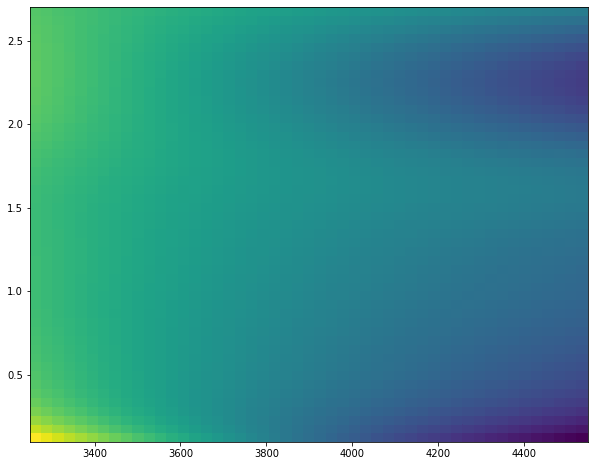

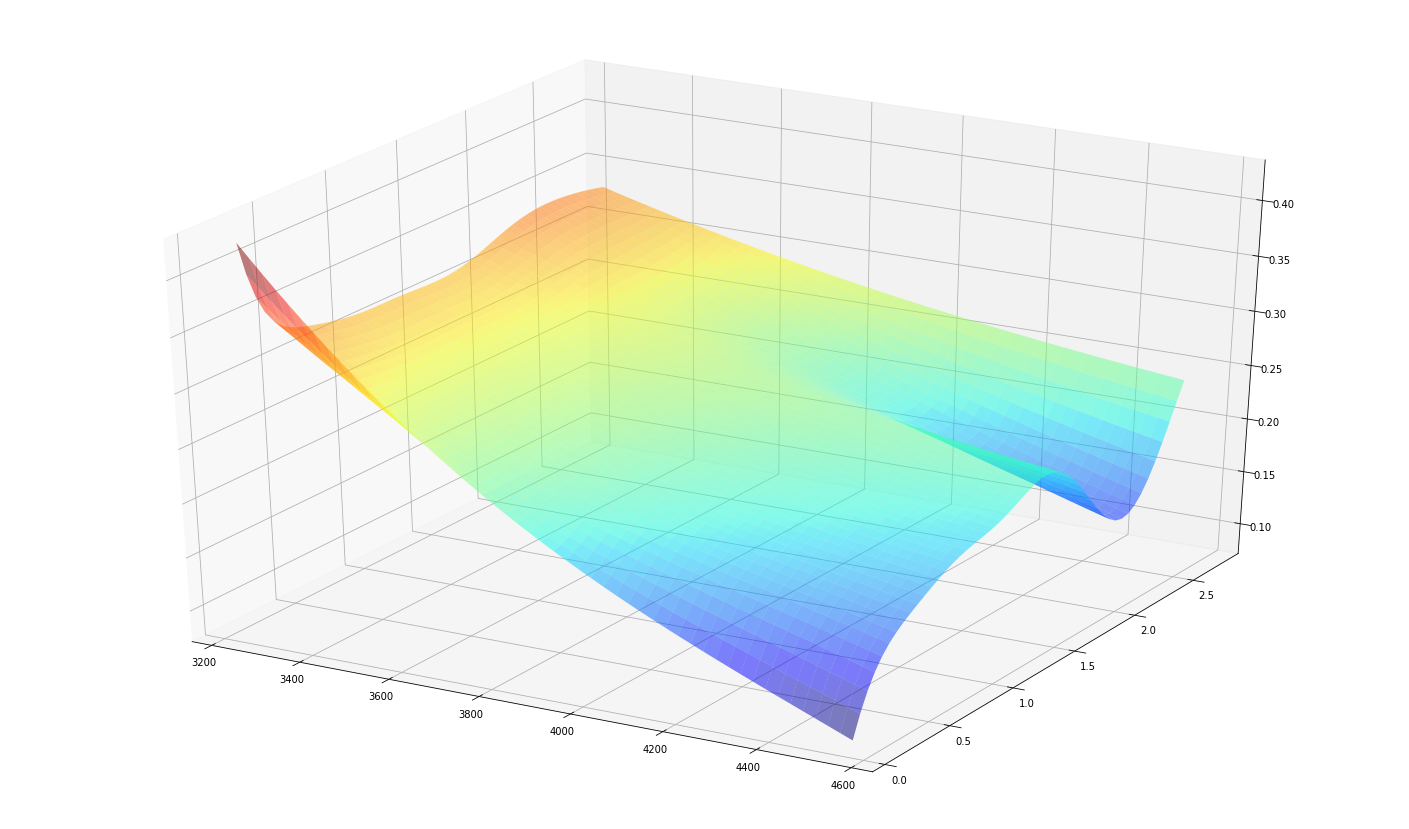

In [1005]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


# The training set
datapoints = jk[['Strikes','TTM','IV']].sort_values(by='Strikes').values
X = datapoints[:,:2]
Y = datapoints[:,-1]

# Gaussian Process

x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(0.0, (1e-3, 1e3)) + RBF([1,1]) + WhiteKernel(noise_level = 1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, Y)

x1x2 = np.array(list(product(x1, x2)))
y_pred = gp.predict(x1x2)

print('R squared = ',gp.score(X, Y))

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)


fig = plt.figure(figsize=(25, 15))
ax1 = fig.add_subplot(projection='3d')       
surf = ax1.plot_surface(X0p, X1p, Zp,rstride=1, cstride=1,cmap='jet', alpha=0.5)

plt.show()